## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp023'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 5e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

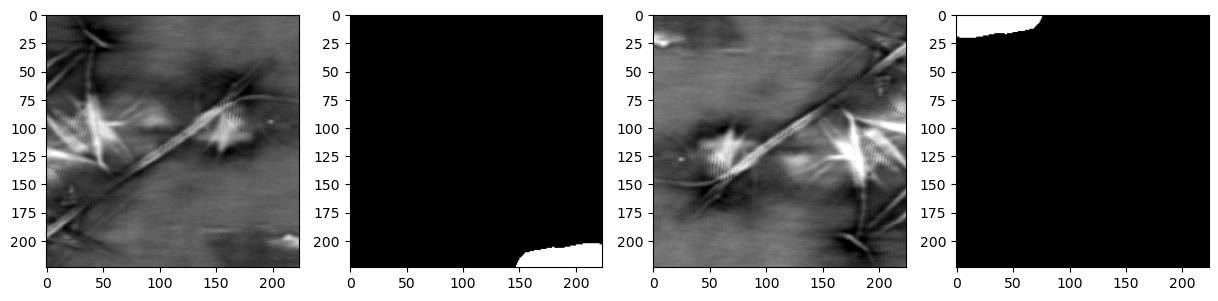

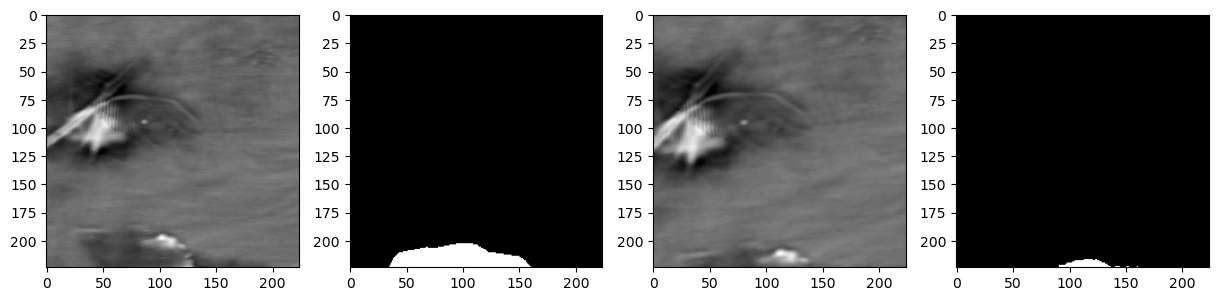

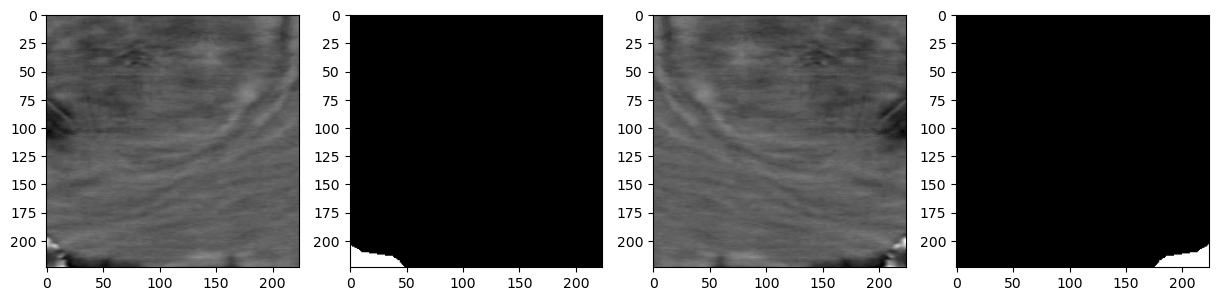

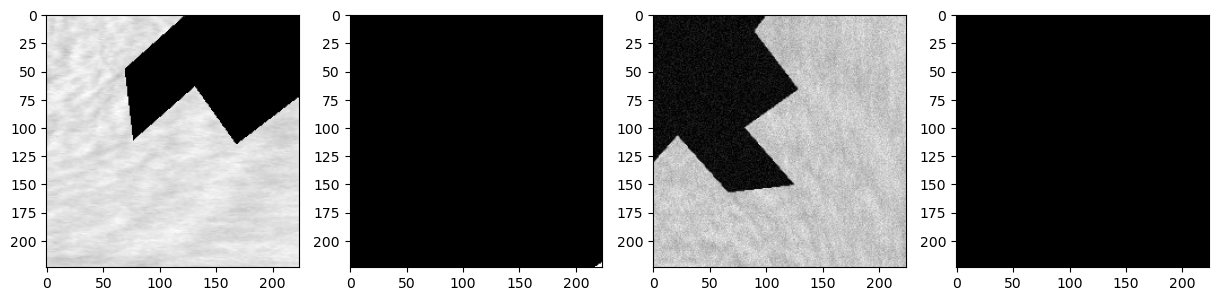

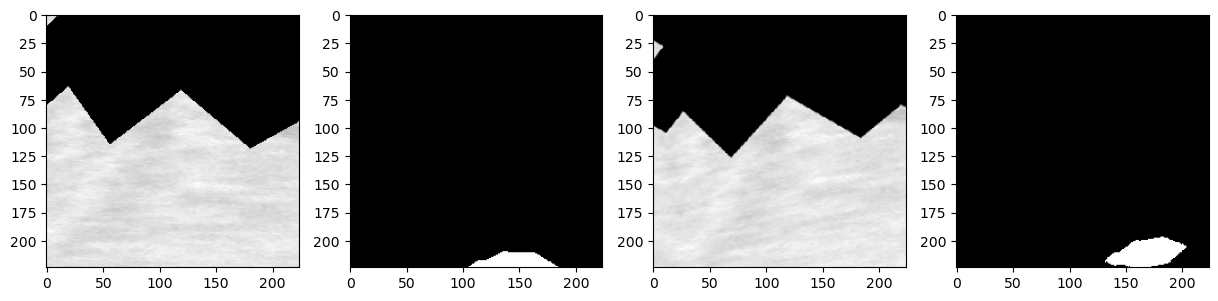

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48150

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.23809303572882454
th: 0.15, fbeta: 0.2872214181701161
th: 0.2, fbeta: 0.3558602660454899
th: 0.25, fbeta: 0.41001164714726474
th: 0.3, fbeta: 0.4300437785937873
th: 0.35, fbeta: 0.4336694346898435
th: 0.4, fbeta: 0.4205345287732111
th: 0.45, fbeta: 0.3885749532446205


best_th: 0.35, fbeta: 0.4336694346898435
Epoch 1 - avg_train_loss: 0.3913  avg_val_loss: 0.2671  time: 148s
Epoch 1 - avgScore: 0.4337
Epoch 1 - Save Best Score: 0.4337 Model
Epoch 1 - Save Best Loss: 0.2671 Model


th: 0.5, fbeta: 0.30229195612031107


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3148720138836019
th: 0.15, fbeta: 0.36750451163931297
th: 0.2, fbeta: 0.40187615173632896
th: 0.25, fbeta: 0.4282897717832156
th: 0.3, fbeta: 0.45083201779129217
th: 0.35, fbeta: 0.47109439161811656
th: 0.4, fbeta: 0.4840953394323108
th: 0.45, fbeta: 0.4871858340638817


best_th: 0.45, fbeta: 0.4871858340638817
Epoch 2 - avg_train_loss: 0.2695  avg_val_loss: 0.2377  time: 151s
Epoch 2 - avgScore: 0.4872
Epoch 2 - Save Best Score: 0.4872 Model
Epoch 2 - Save Best Loss: 0.2377 Model


th: 0.5, fbeta: 0.4802744083231022


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.35259870281416916
th: 0.15, fbeta: 0.43491943730081184
th: 0.2, fbeta: 0.37158625229523545
th: 0.25, fbeta: 0.30768528895944414
th: 0.3, fbeta: 0.253878136313908
th: 0.35, fbeta: 0.2043169858431357
th: 0.4, fbeta: 0.16104935596387993
th: 0.45, fbeta: 0.12413130400018745


best_th: 0.15, fbeta: 0.43491943730081184
Epoch 3 - avg_train_loss: 0.2881  avg_val_loss: 0.2612  time: 151s
Epoch 3 - avgScore: 0.4349


th: 0.5, fbeta: 0.0964256280345889


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2375185950456174
th: 0.15, fbeta: 0.25263828475132694
th: 0.2, fbeta: 0.2717283708610646
th: 0.25, fbeta: 0.2913392423060144
th: 0.3, fbeta: 0.3096776000011918
th: 0.35, fbeta: 0.32860912073093473
th: 0.4, fbeta: 0.3470416828636607
th: 0.45, fbeta: 0.36389306913735836


best_th: 0.5, fbeta: 0.3800616842497447
Epoch 4 - avg_train_loss: 0.2692  avg_val_loss: 0.3239  time: 150s
Epoch 4 - avgScore: 0.3801


th: 0.5, fbeta: 0.3800616842497447


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3126975936958695
th: 0.15, fbeta: 0.3510793160622341
th: 0.2, fbeta: 0.38924901825285835
th: 0.25, fbeta: 0.42922067224345567
th: 0.3, fbeta: 0.4589463832135013
th: 0.35, fbeta: 0.46948658412830546
th: 0.4, fbeta: 0.4597870356881074
th: 0.45, fbeta: 0.4287368005146049


best_th: 0.35, fbeta: 0.46948658412830546
Epoch 5 - avg_train_loss: 0.2612  avg_val_loss: 0.2307  time: 150s
Epoch 5 - avgScore: 0.4695


th: 0.5, fbeta: 0.385479608879769


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2949444195953023
th: 0.15, fbeta: 0.32101697736668805
th: 0.2, fbeta: 0.3454954081054284
th: 0.25, fbeta: 0.37292238302818864
th: 0.3, fbeta: 0.4029537565312433
th: 0.35, fbeta: 0.4350840846107052
th: 0.4, fbeta: 0.46845190135865306
th: 0.45, fbeta: 0.49268586739070774


best_th: 0.5, fbeta: 0.5022551174331031
Epoch 6 - avg_train_loss: 0.2535  avg_val_loss: 0.2328  time: 151s
Epoch 6 - avgScore: 0.5023
Epoch 6 - Save Best Score: 0.5023 Model
Epoch 6 - Save Best Loss: 0.2328 Model


th: 0.5, fbeta: 0.5022551174331031


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2915465687869295
th: 0.15, fbeta: 0.32815755101945643
th: 0.2, fbeta: 0.3552422153500256
th: 0.25, fbeta: 0.3817764556273953
th: 0.3, fbeta: 0.4049448422069035
th: 0.35, fbeta: 0.42313499634963975
th: 0.4, fbeta: 0.43375013835379855
th: 0.45, fbeta: 0.4426815002060032


best_th: 0.5, fbeta: 0.446576229720702
Epoch 7 - avg_train_loss: 0.2491  avg_val_loss: 0.2378  time: 151s
Epoch 7 - avgScore: 0.4466


th: 0.5, fbeta: 0.446576229720702


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25890091537721377
th: 0.15, fbeta: 0.27730792421690453
th: 0.2, fbeta: 0.2951456155387539
th: 0.25, fbeta: 0.3125471123499487
th: 0.3, fbeta: 0.32970707199434757
th: 0.35, fbeta: 0.3478881295409393
th: 0.4, fbeta: 0.36701065398742316
th: 0.45, fbeta: 0.3875568497135585


best_th: 0.5, fbeta: 0.40896910964470073
Epoch 8 - avg_train_loss: 0.2430  avg_val_loss: 0.2961  time: 151s
Epoch 8 - avgScore: 0.4090


th: 0.5, fbeta: 0.40896910964470073


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2715611419317008
th: 0.15, fbeta: 0.29456617543740304
th: 0.2, fbeta: 0.31661944510006695
th: 0.25, fbeta: 0.3395042901418164
th: 0.3, fbeta: 0.36506638574610195
th: 0.35, fbeta: 0.38879812049610485
th: 0.4, fbeta: 0.40857605754144793
th: 0.45, fbeta: 0.4260507139992452


best_th: 0.5, fbeta: 0.438205454635432
Epoch 9 - avg_train_loss: 0.2388  avg_val_loss: 0.2540  time: 151s
Epoch 9 - avgScore: 0.4382


th: 0.5, fbeta: 0.438205454635432


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3271844576788852
th: 0.15, fbeta: 0.36963204758447965
th: 0.2, fbeta: 0.40339172486260266
th: 0.25, fbeta: 0.43205481976850674
th: 0.3, fbeta: 0.45483557531164814
th: 0.35, fbeta: 0.4771976729054173
th: 0.4, fbeta: 0.4928003967764229
th: 0.45, fbeta: 0.5014168761469732


best_th: 0.5, fbeta: 0.5059479663439119
Epoch 10 - avg_train_loss: 0.2360  avg_val_loss: 0.2266  time: 150s
Epoch 10 - avgScore: 0.5059
Epoch 10 - Save Best Score: 0.5059 Model
Epoch 10 - Save Best Loss: 0.2266 Model


th: 0.5, fbeta: 0.5059479663439119


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2910529465832791
th: 0.15, fbeta: 0.3179777801488188
th: 0.2, fbeta: 0.34296718797854253
th: 0.25, fbeta: 0.36739691417729986
th: 0.3, fbeta: 0.39199805082167904
th: 0.35, fbeta: 0.4174960306223695
th: 0.4, fbeta: 0.44055427442052925
th: 0.45, fbeta: 0.4610908451773932


best_th: 0.5, fbeta: 0.4739206981914217
Epoch 11 - avg_train_loss: 0.2315  avg_val_loss: 0.2502  time: 151s
Epoch 11 - avgScore: 0.4739


th: 0.5, fbeta: 0.4739206981914217


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4393516881613242
th: 0.15, fbeta: 0.47058806439676926
th: 0.2, fbeta: 0.49600254095995594
th: 0.25, fbeta: 0.514109382205662
th: 0.3, fbeta: 0.5211131161604641
th: 0.35, fbeta: 0.5192384743106956
th: 0.4, fbeta: 0.514226906084523
th: 0.45, fbeta: 0.500909112436699


best_th: 0.3, fbeta: 0.5211131161604641
Epoch 12 - avg_train_loss: 0.2274  avg_val_loss: 0.2652  time: 150s
Epoch 12 - avgScore: 0.5211
Epoch 12 - Save Best Score: 0.5211 Model
Epoch 12 - Save Best Loss: 0.2652 Model


th: 0.5, fbeta: 0.47957739113844017


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37423109295469875
th: 0.15, fbeta: 0.4200635406163815
th: 0.2, fbeta: 0.44502193028644843
th: 0.25, fbeta: 0.4645981257193766
th: 0.3, fbeta: 0.4772421724315685
th: 0.35, fbeta: 0.48511888432021827
th: 0.4, fbeta: 0.4872000447473634
th: 0.45, fbeta: 0.4889814168382771


best_th: 0.5, fbeta: 0.49000437446048867
Epoch 13 - avg_train_loss: 0.2255  avg_val_loss: 0.2334  time: 151s
Epoch 13 - avgScore: 0.4900


th: 0.5, fbeta: 0.49000437446048867


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3537256128842886
th: 0.15, fbeta: 0.38009051750650286
th: 0.2, fbeta: 0.3968406032121759
th: 0.25, fbeta: 0.4113825385439576
th: 0.3, fbeta: 0.4210399234722753
th: 0.35, fbeta: 0.424101425875779
th: 0.4, fbeta: 0.41850540816011245
th: 0.45, fbeta: 0.40944341211910895


best_th: 0.35, fbeta: 0.424101425875779
Epoch 14 - avg_train_loss: 0.2209  avg_val_loss: 0.2593  time: 150s
Epoch 14 - avgScore: 0.4241


th: 0.5, fbeta: 0.3968243772060961


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3222400428067808
th: 0.15, fbeta: 0.3697834496538537
th: 0.2, fbeta: 0.4161974475437334
th: 0.25, fbeta: 0.4591518326481875
th: 0.3, fbeta: 0.49223581140040107
th: 0.35, fbeta: 0.5153909300306583
th: 0.4, fbeta: 0.531479835217966
th: 0.45, fbeta: 0.5389027919095907


best_th: 0.45, fbeta: 0.5389027919095907
Epoch 15 - avg_train_loss: 0.2168  avg_val_loss: 0.2159  time: 151s
Epoch 15 - avgScore: 0.5389
Epoch 15 - Save Best Score: 0.5389 Model
Epoch 15 - Save Best Loss: 0.2159 Model


th: 0.5, fbeta: 0.534539434891768


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37252596724202863
th: 0.15, fbeta: 0.4108671955496264
th: 0.2, fbeta: 0.4431190403618697
th: 0.25, fbeta: 0.4717632800047644
th: 0.3, fbeta: 0.4965345307304748
th: 0.35, fbeta: 0.5172093509249153
th: 0.4, fbeta: 0.5273099539857431
th: 0.45, fbeta: 0.5299003928775046


best_th: 0.45, fbeta: 0.5299003928775046
Epoch 16 - avg_train_loss: 0.2118  avg_val_loss: 0.2325  time: 152s
Epoch 16 - avgScore: 0.5299


th: 0.5, fbeta: 0.5256529867610705


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3455960524353148
th: 0.15, fbeta: 0.3761892590737579
th: 0.2, fbeta: 0.4002840589569389
th: 0.25, fbeta: 0.42235453475014956
th: 0.3, fbeta: 0.44165212943627463
th: 0.35, fbeta: 0.46021254232936076
th: 0.4, fbeta: 0.4766154389568206
th: 0.45, fbeta: 0.4913848811018288


best_th: 0.5, fbeta: 0.5033936933847958
Epoch 17 - avg_train_loss: 0.2077  avg_val_loss: 0.2433  time: 150s
Epoch 17 - avgScore: 0.5034


th: 0.5, fbeta: 0.5033936933847958


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3680549627223808
th: 0.15, fbeta: 0.3984545245893612
th: 0.2, fbeta: 0.42655413019439636
th: 0.25, fbeta: 0.45019456279387515
th: 0.3, fbeta: 0.47189213959009507
th: 0.35, fbeta: 0.48784562206991094
th: 0.4, fbeta: 0.5028678804911404
th: 0.45, fbeta: 0.5182247132966173


best_th: 0.5, fbeta: 0.5295304749059594
Epoch 18 - avg_train_loss: 0.2015  avg_val_loss: 0.2380  time: 151s
Epoch 18 - avgScore: 0.5295


th: 0.5, fbeta: 0.5295304749059594


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4163054462753587
th: 0.15, fbeta: 0.4533220592892242
th: 0.2, fbeta: 0.47434457916447625
th: 0.25, fbeta: 0.4855124337314537
th: 0.3, fbeta: 0.4966967993568306
th: 0.35, fbeta: 0.4962220910427619
th: 0.4, fbeta: 0.486431257574684
th: 0.45, fbeta: 0.4715936134425076


best_th: 0.3, fbeta: 0.4966967993568306
Epoch 19 - avg_train_loss: 0.1972  avg_val_loss: 0.2586  time: 150s
Epoch 19 - avgScore: 0.4967


th: 0.5, fbeta: 0.45158542866101853


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43062426762865724
th: 0.15, fbeta: 0.47449760748476655
th: 0.2, fbeta: 0.5000272402732944
th: 0.25, fbeta: 0.5214157191586225
th: 0.3, fbeta: 0.532331897395978
th: 0.35, fbeta: 0.5391280054907446
th: 0.4, fbeta: 0.5403679922218673
th: 0.45, fbeta: 0.5351809999416964


best_th: 0.4, fbeta: 0.5403679922218673
Epoch 20 - avg_train_loss: 0.1919  avg_val_loss: 0.2552  time: 151s
Epoch 20 - avgScore: 0.5404
Epoch 20 - Save Best Score: 0.5404 Model
Epoch 20 - Save Best Loss: 0.2552 Model


th: 0.5, fbeta: 0.5236260964637198


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4527065436051987
th: 0.15, fbeta: 0.4954388851582845
th: 0.2, fbeta: 0.517427233101741
th: 0.25, fbeta: 0.5300005068011114
th: 0.3, fbeta: 0.5368079879814107
th: 0.35, fbeta: 0.5325209550322997
th: 0.4, fbeta: 0.5238902850610019
th: 0.45, fbeta: 0.5114099604727518


best_th: 0.3, fbeta: 0.5368079879814107
Epoch 21 - avg_train_loss: 0.1875  avg_val_loss: 0.2546  time: 151s
Epoch 21 - avgScore: 0.5368


th: 0.5, fbeta: 0.4939867986668443


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.423224388823538
th: 0.15, fbeta: 0.4588805607470238
th: 0.2, fbeta: 0.49054772895532606
th: 0.25, fbeta: 0.5185837826409918
th: 0.3, fbeta: 0.5394637050026047
th: 0.35, fbeta: 0.5543941161446049
th: 0.4, fbeta: 0.5643532846769939
th: 0.45, fbeta: 0.5725957696145936


best_th: 0.5, fbeta: 0.5764259152359084
Epoch 22 - avg_train_loss: 0.1804  avg_val_loss: 0.2351  time: 150s
Epoch 22 - avgScore: 0.5764
Epoch 22 - Save Best Score: 0.5764 Model
Epoch 22 - Save Best Loss: 0.2351 Model


th: 0.5, fbeta: 0.5764259152359084


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4159258010335201
th: 0.15, fbeta: 0.45798738930827604
th: 0.2, fbeta: 0.48803223805127877
th: 0.25, fbeta: 0.5044908454461071
th: 0.3, fbeta: 0.517771474365871
th: 0.35, fbeta: 0.5257850067297701
th: 0.4, fbeta: 0.5358570588278038
th: 0.45, fbeta: 0.5441593035289737


best_th: 0.5, fbeta: 0.5457040102745117
Epoch 23 - avg_train_loss: 0.1747  avg_val_loss: 0.2431  time: 151s
Epoch 23 - avgScore: 0.5457


th: 0.5, fbeta: 0.5457040102745117


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3791697939193061
th: 0.15, fbeta: 0.4167687706744912
th: 0.2, fbeta: 0.44932509285878786
th: 0.25, fbeta: 0.4770799112506721
th: 0.3, fbeta: 0.49960508270573495
th: 0.35, fbeta: 0.5185395983140753
th: 0.4, fbeta: 0.53264944520758
th: 0.45, fbeta: 0.5428415536863852


best_th: 0.5, fbeta: 0.548254725883838
Epoch 24 - avg_train_loss: 0.1692  avg_val_loss: 0.2310  time: 150s
Epoch 24 - avgScore: 0.5483


th: 0.5, fbeta: 0.548254725883838


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45576190074629785
th: 0.15, fbeta: 0.4909473238962783
th: 0.2, fbeta: 0.5165924908433388
th: 0.25, fbeta: 0.5316327587283903
th: 0.3, fbeta: 0.540331574845129
th: 0.35, fbeta: 0.5452639899284056
th: 0.4, fbeta: 0.550133589337122
th: 0.45, fbeta: 0.5494246295926734


best_th: 0.4, fbeta: 0.550133589337122
Epoch 25 - avg_train_loss: 0.1675  avg_val_loss: 0.2612  time: 150s
Epoch 25 - avgScore: 0.5501


th: 0.5, fbeta: 0.5392990500385398


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41352257514701113
th: 0.15, fbeta: 0.45443797734482694
th: 0.2, fbeta: 0.4887900453870261
th: 0.25, fbeta: 0.5157238558700569
th: 0.3, fbeta: 0.5373951915736056
th: 0.35, fbeta: 0.5511100349488881
th: 0.4, fbeta: 0.5562724015133439
th: 0.45, fbeta: 0.5605043034564422


best_th: 0.5, fbeta: 0.5606663187266937
Epoch 26 - avg_train_loss: 0.1619  avg_val_loss: 0.2439  time: 151s
Epoch 26 - avgScore: 0.5607


th: 0.5, fbeta: 0.5606663187266937


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4315782881352031
th: 0.15, fbeta: 0.4651638666312844
th: 0.2, fbeta: 0.48863165606147674
th: 0.25, fbeta: 0.5021583443780419
th: 0.3, fbeta: 0.513820265442005
th: 0.35, fbeta: 0.5209665534497341
th: 0.4, fbeta: 0.5231441367860254
th: 0.45, fbeta: 0.5236707013121907


best_th: 0.45, fbeta: 0.5236707013121907
Epoch 27 - avg_train_loss: 0.1573  avg_val_loss: 0.2632  time: 151s
Epoch 27 - avgScore: 0.5237


th: 0.5, fbeta: 0.5230331837185278


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42565746370237717
th: 0.15, fbeta: 0.463319104674823
th: 0.2, fbeta: 0.4890618590214973
th: 0.25, fbeta: 0.507197666349197
th: 0.3, fbeta: 0.5194984429084449
th: 0.35, fbeta: 0.527950361185268
th: 0.4, fbeta: 0.5350507126540476
th: 0.45, fbeta: 0.5392962116195158


best_th: 0.5, fbeta: 0.5396852281160353
Epoch 28 - avg_train_loss: 0.1570  avg_val_loss: 0.2615  time: 151s
Epoch 28 - avgScore: 0.5397


th: 0.5, fbeta: 0.5396852281160353


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45129036305570164
th: 0.15, fbeta: 0.48826297500719035
th: 0.2, fbeta: 0.5090172656672183
th: 0.25, fbeta: 0.5210902373151728
th: 0.3, fbeta: 0.530384554823912
th: 0.35, fbeta: 0.537143561744602
th: 0.4, fbeta: 0.5422333977682834
th: 0.45, fbeta: 0.5427557134748825


best_th: 0.45, fbeta: 0.5427557134748825
Epoch 29 - avg_train_loss: 0.1532  avg_val_loss: 0.2760  time: 151s
Epoch 29 - avgScore: 0.5428


th: 0.5, fbeta: 0.5405555482043339


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43536213761796455
th: 0.15, fbeta: 0.4755444404737048
th: 0.2, fbeta: 0.5020034484268391
th: 0.25, fbeta: 0.5177078065310105
th: 0.3, fbeta: 0.5259178831310548
th: 0.35, fbeta: 0.5327733427271171
th: 0.4, fbeta: 0.5394457373939472
th: 0.45, fbeta: 0.5421671648115521


best_th: 0.45, fbeta: 0.5421671648115521
Epoch 30 - avg_train_loss: 0.1509  avg_val_loss: 0.2646  time: 151s
Epoch 30 - avgScore: 0.5422


th: 0.5, fbeta: 0.5402970381352445


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.423224388823538
th: 0.15, fbeta: 0.4588805607470238
th: 0.2, fbeta: 0.49054772895532606
th: 0.25, fbeta: 0.5185837826409918
th: 0.3, fbeta: 0.5394637050026047
th: 0.35, fbeta: 0.5543941161446049
th: 0.4, fbeta: 0.5643532846769939
th: 0.45, fbeta: 0.5725957696145936


best_th: 0.5, fbeta: 0.5764259152359084


th: 0.5, fbeta: 0.5764259152359084


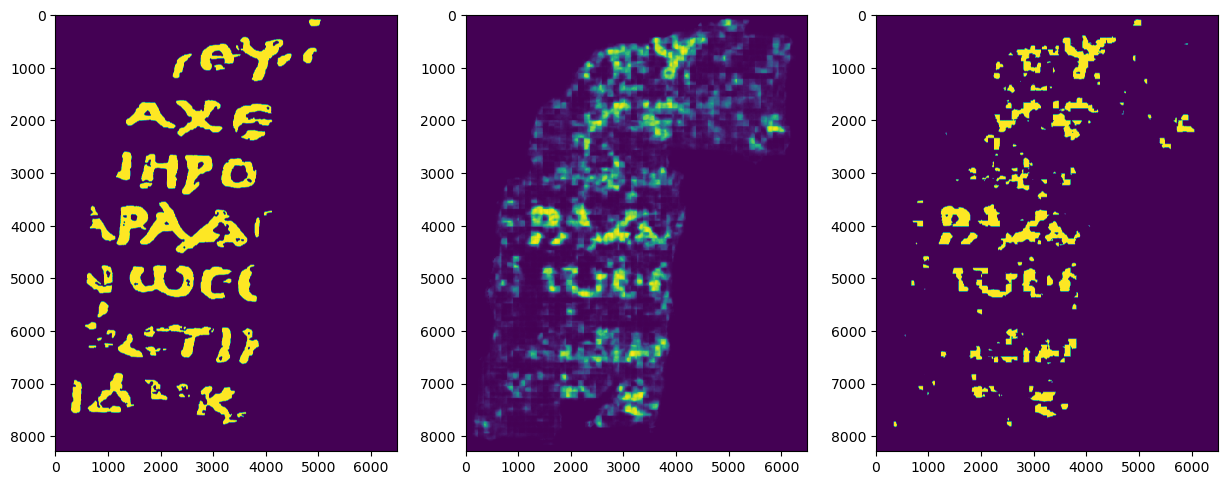

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([39519410.,  4033525.,  1849183.,  1273259.,  1028652.,   859257.,
          724823.,   593964.,   517792.,   435598.,   380765.,   352343.,
          326482.,   334416.,   328342.,   309551.,   298011.,   273558.,
          243558.,   156359.]),
 array([3.36939841e-10, 4.96949415e-02, 9.93898827e-02, 1.49084824e-01,
        1.98779765e-01, 2.48474706e-01, 2.98169647e-01, 3.47864589e-01,
        3.97559530e-01, 4.47254471e-01, 4.96949412e-01, 5.46644353e-01,
        5.96339294e-01, 6.46034236e-01, 6.95729177e-01, 7.45424118e-01,
        7.95119059e-01, 8.44814000e-01, 8.94508942e-01, 9.44203883e-01,
        9.93898824e-01]),
 <BarContainer object of 20 artists>)

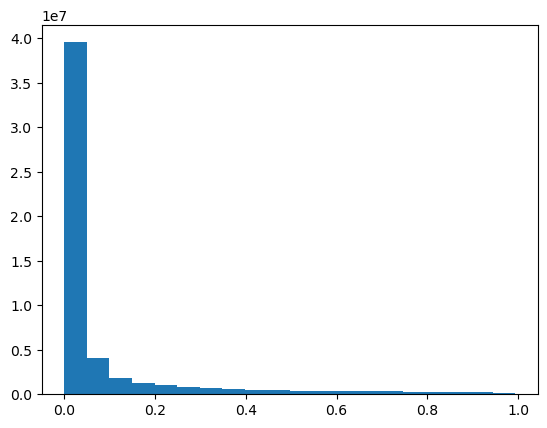

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000